In [455]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [456]:
df = pd.read_csv('../data/web_response.csv', parse_dates=['point'], index_col='point')

In [457]:
df = df.head(40000)


In [520]:

train_size = int(len(df) * 0.92)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(36800, 1) (3200, 1)


In [521]:
from sklearn.preprocessing import StandardScaler

value_key = 'web_response'

scaler = StandardScaler()
scaler = scaler.fit(train[[value_key]])

train[value_key] = scaler.transform(train[[value_key]])
test[value_key] = scaler.transform(test[[value_key]])


/var/folders/t8/drf96cn57_g4mp7xh4n29g200000gn/T/ipykernel_72622/1646131435.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[value_key] = scaler.transform(train[[value_key]])
/var/folders/t8/drf96cn57_g4mp7xh4n29g200000gn/T/ipykernel_72622/1646131435.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[value_key] = scaler.transform(test[[value_key]])


In [522]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [523]:
TIME_STEPS = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[[value_key]], train[value_key], TIME_STEPS)
X_test, y_test = create_dataset(test[[value_key]], test[value_key], TIME_STEPS)

print(X_test.shape)

(3190, 10, 1)


In [488]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

/Users/anatolyefimov/red-hack-time-series-analyzer/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [489]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.2294 - val_loss: 0.2504
Epoch 2/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.2079 - val_loss: 0.2522
Epoch 3/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.2053 - val_loss: 0.2518
Epoch 4/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.2032 - val_loss: 0.2500
Epoch 5/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.2020 - val_loss: 0.2494
Epoch 6/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.2010 - val_loss: 0.2493
Epoch 7/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.2006 - val_loss: 0.2491
Epoch 8/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.2001 - val_loss: 0.2481
Epoch 9/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1998 - val_loss: 0.2480
Epoch 10/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.1996 - val_loss: 0.2479
Epoch 11/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.1992 - val_loss: 0.2478
Epoch 12/20
1091/1091 ━━━━━━━━

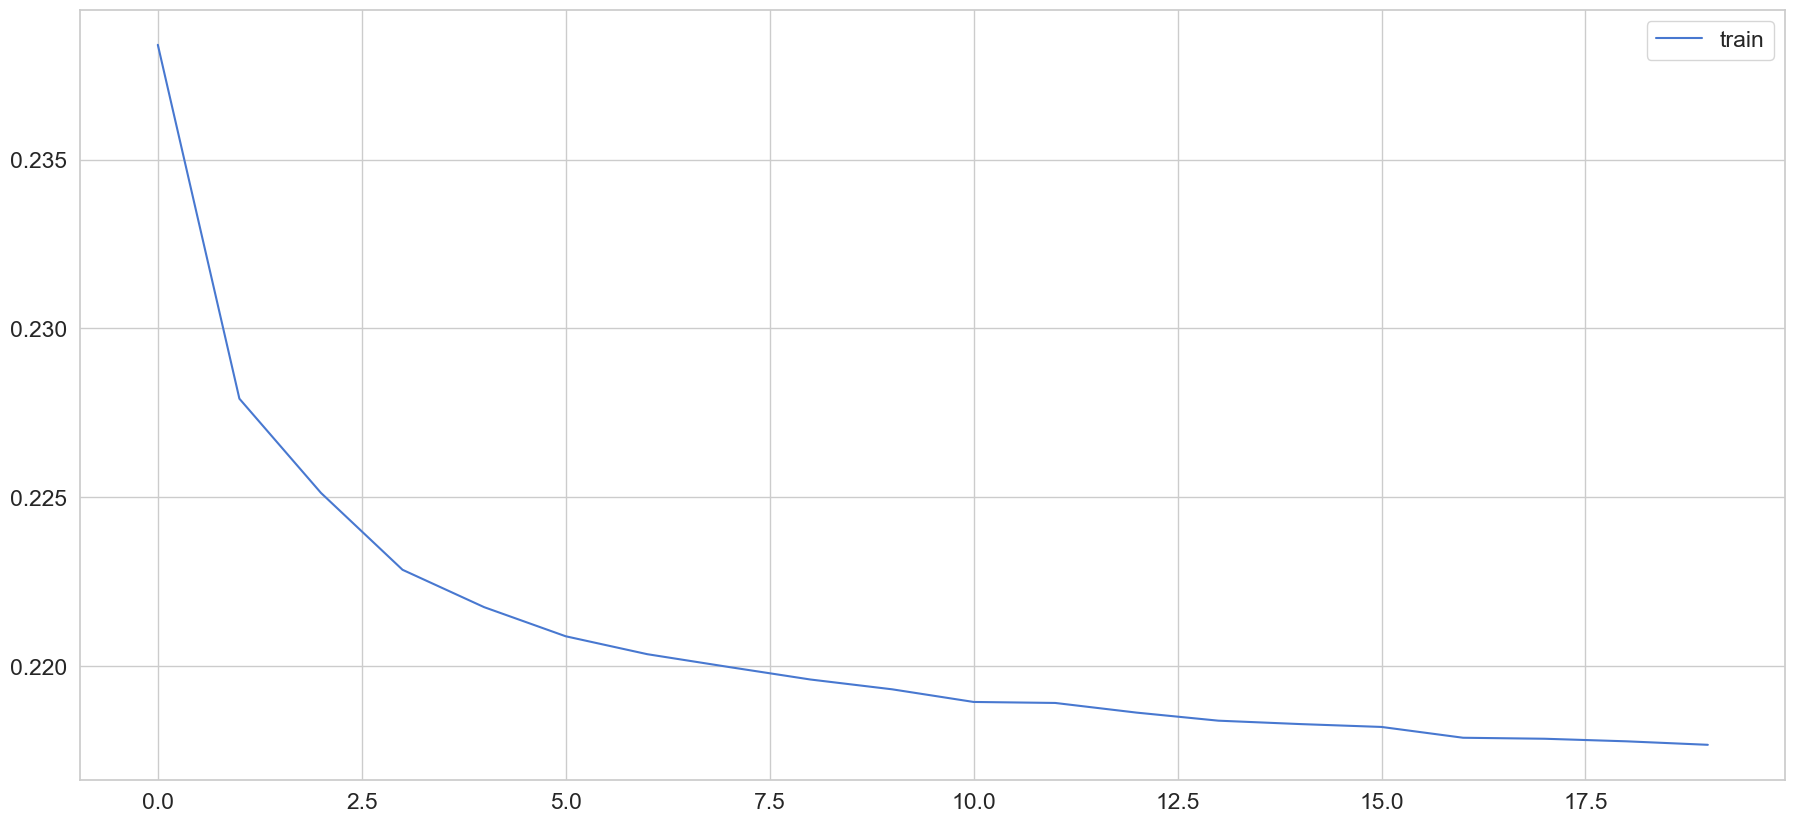

In [490]:
plt.plot(history.history['loss'], label='train')

plt.legend();

In [491]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

1213/1213 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


/var/folders/t8/drf96cn57_g4mp7xh4n29g200000gn/T/ipykernel_72622/1731640021.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_mae_loss, bins=50, kde=True);


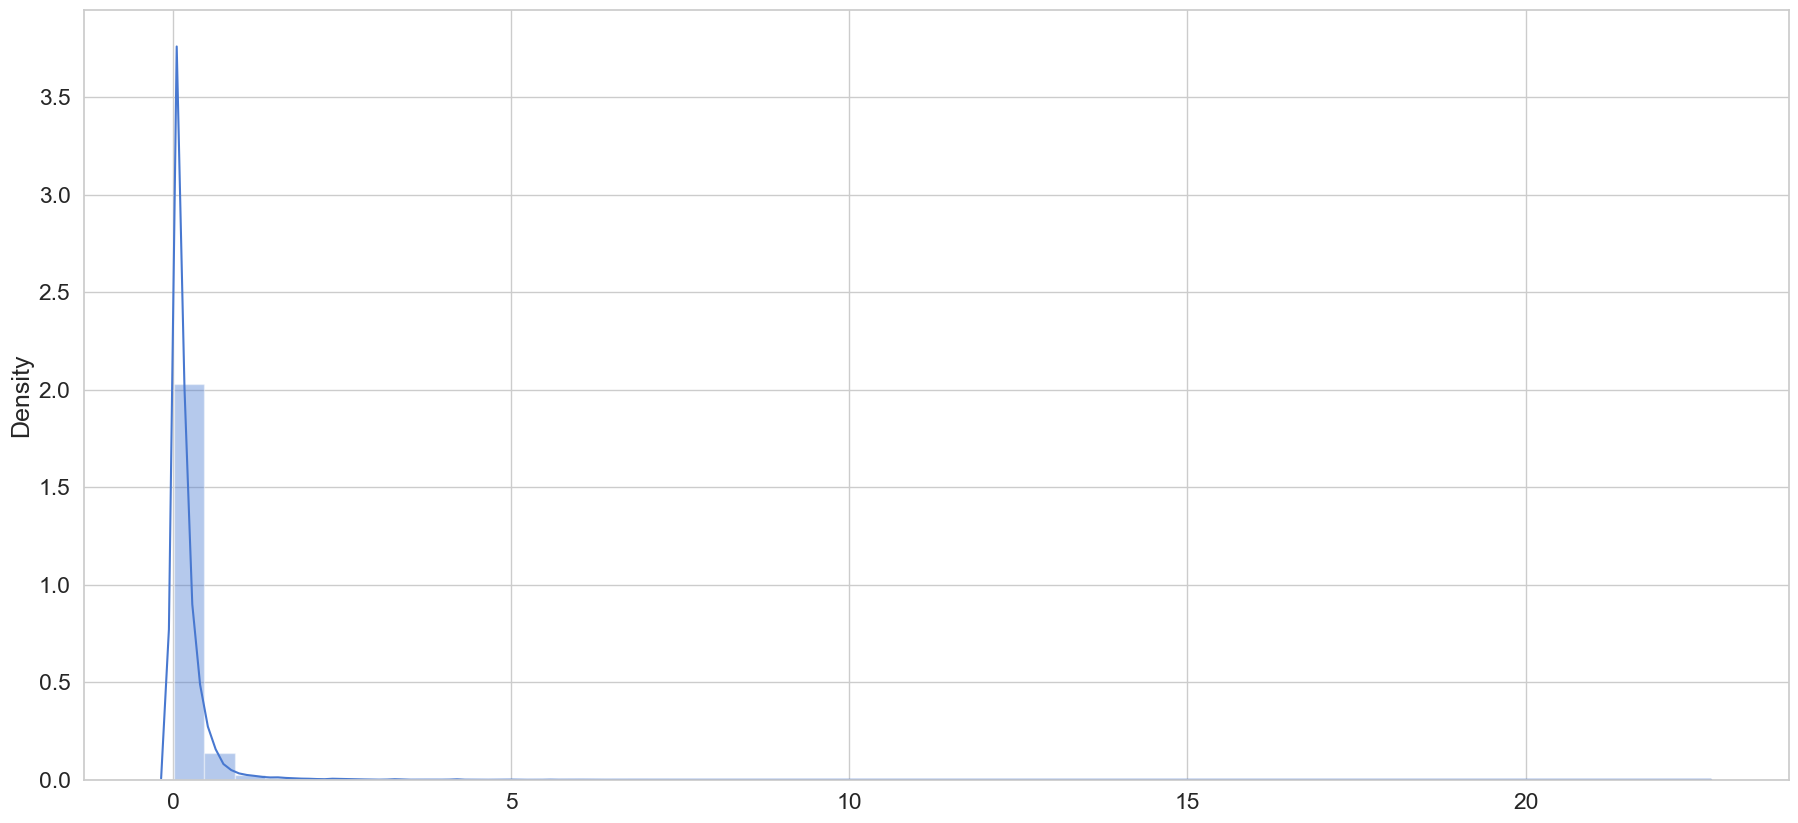

In [492]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [524]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/var/folders/t8/drf96cn57_g4mp7xh4n29g200000gn/T/ipykernel_72622/1731640021.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_mae_loss, bins=50, kde=True);


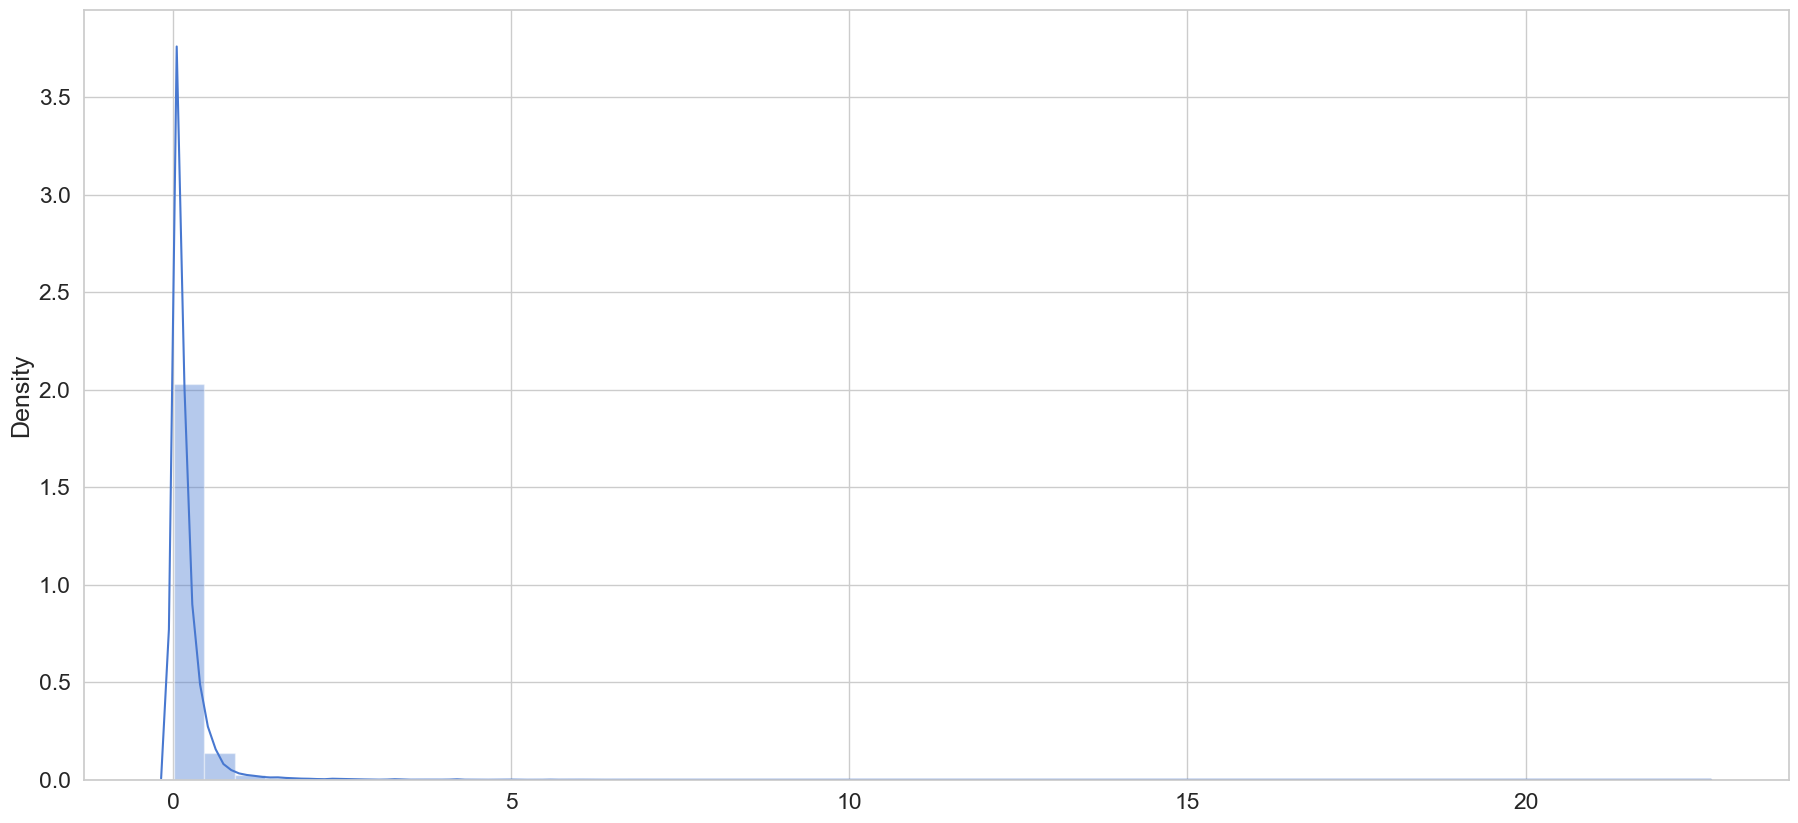

In [525]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [534]:
THRESHOLD = 0.5

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df[value_key] = test[TIME_STEPS:][value_key]

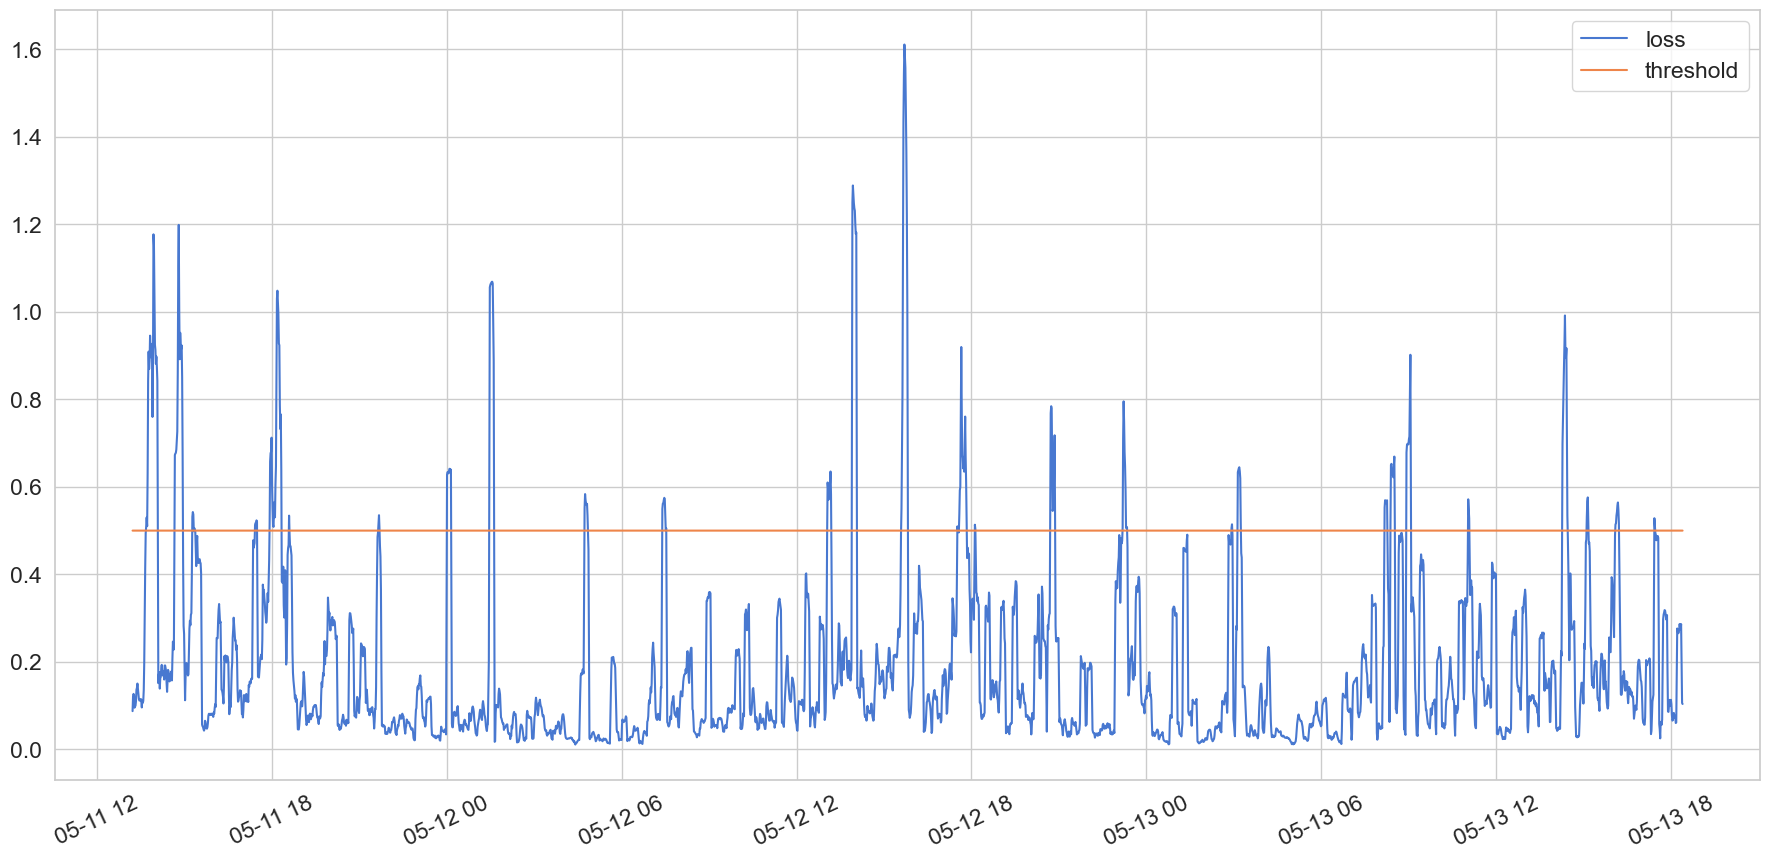

In [535]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [536]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,web_response
point,,,,
2024-05-11 13:42:00,0.509115,0.5,True,0.733232
2024-05-11 13:43:00,0.530096,0.5,True,0.436958
2024-05-11 13:44:00,0.510151,0.5,True,1.902159
2024-05-11 13:45:00,0.631208,0.5,True,2.774183
2024-05-11 13:46:00,0.842350,0.5,True,1.028203


                     web_response
point                            
2024-04-15 23:32:00      0.007722
2024-04-15 23:33:00      0.008363
2024-04-15 23:34:00      0.008709
2024-04-15 23:35:00      0.008286
2024-04-15 23:36:00      0.010874


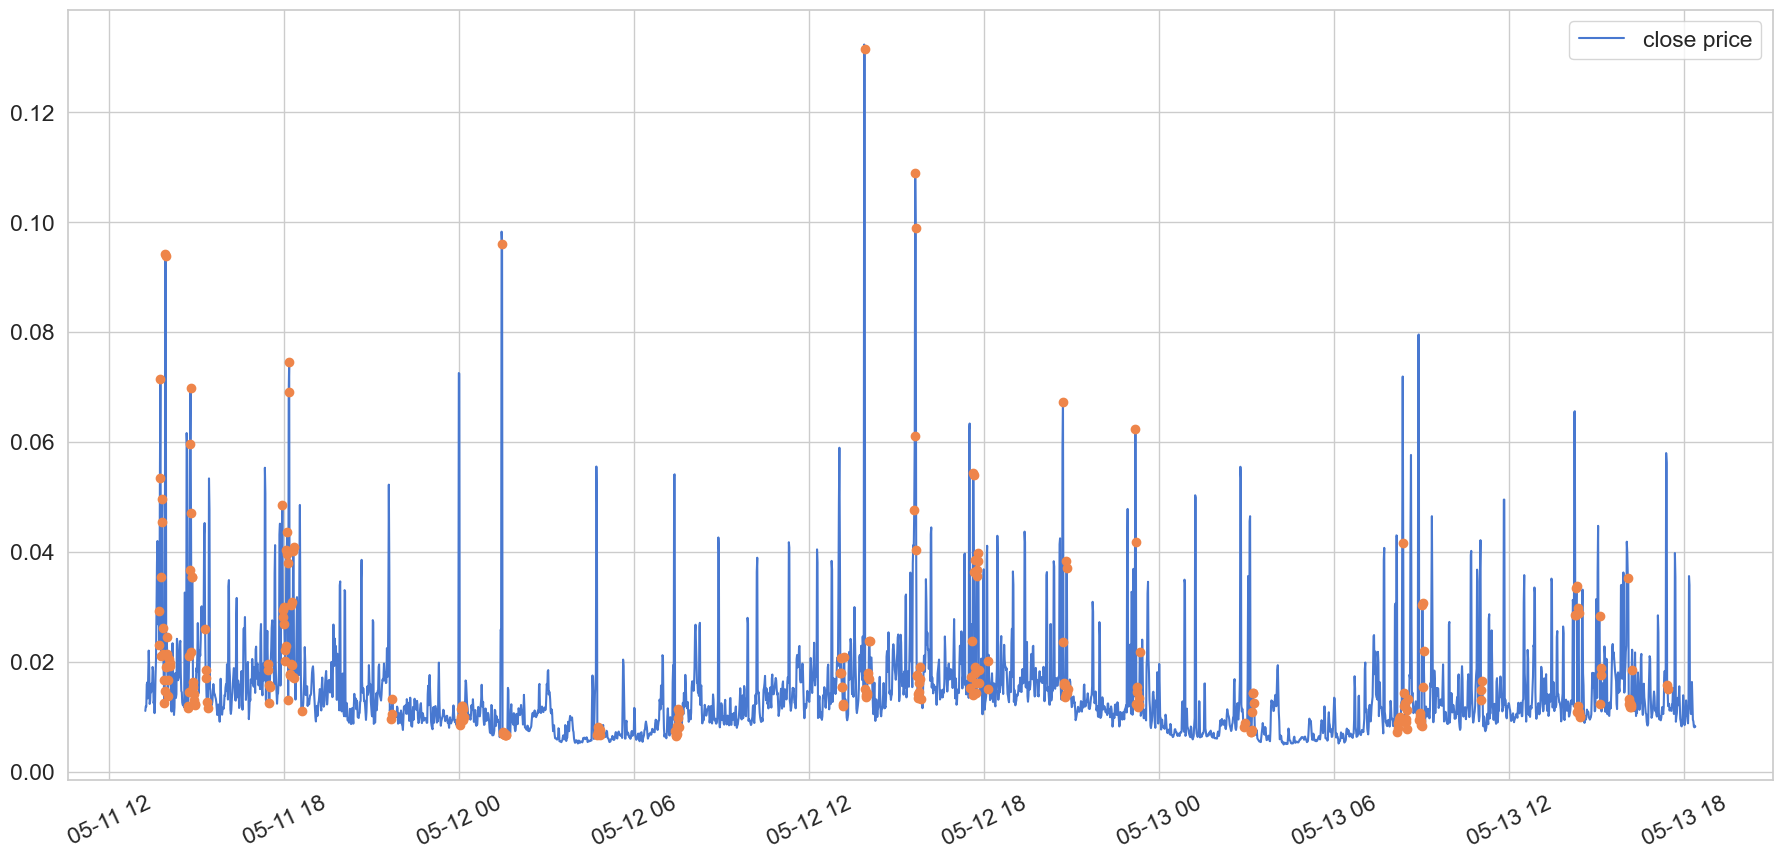

In [537]:

print(df.head())
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:][[value_key]]), 
  label='close price'
);


plt.plot(
  anomalies.index,
  scaler.inverse_transform(anomalies[[value_key]]),
 'o'
)
plt.xticks(rotation=25)
plt.legend();